<a href="https://colab.research.google.com/github/Ale613/Big-Data-Experiments/blob/main/BD_Experiment_with_german_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [28]:
!wget https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz

--2025-03-04 22:15:49--  https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.208.237, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400724056 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.5-bin-hadoop3.tgz.1’

spark-3.5.5-bin-had 100%[===================>] 382.16M  22.7MB/s    in 18s     

2025-03-04 22:16:08 (21.1 MB/s) - ‘spark-3.5.5-bin-hadoop3.tgz.1’ saved [400724056/400724056]



In [29]:
!tar xf spark-3.5.5-bin-hadoop3.tgz

In [30]:
!pip install -q findspark

In [31]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

In [32]:
import findspark
findspark.init()

In [33]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# Creazione Spark Session
spark = SparkSession.builder.appName("EmotionRecognition") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [35]:
from google.colab import files

uploaded = files.upload()

Saving german_dataset.csv to german_dataset.csv


In [36]:
# Percorso del file (se caricato manualmente, si trova in /content/)
file_path = "/content/german_dataset.csv"

In [11]:
# Lettura del CSV con Spark
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [12]:
# Divisione in train e test
df_train, df_test = df.randomSplit([0.8, 0.2], seed=42)

df_train = df_train.repartition(100)  # Dividere il dataset in più partizioni
df_test = df_test.repartition(50)

In [13]:
# Pulizia del testo
def clean_text(df):
    df = df.withColumn("text", lower(col("text")))
    df = df.withColumn("text", regexp_replace(col("text"), "[^a-zA-Z ]", ""))
    return df

df_train = clean_text(df_train)
df_test = clean_text(df_test)

In [14]:
# Label encoding
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
label_indexer_model = label_indexer.fit(df_train)
df_train = label_indexer_model.transform(df_train)
df_test = label_indexer_model.transform(df_test)

In [15]:
# Tokenizzazione e rimozione stopwords
tokenizer = Tokenizer(inputCol="text", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

df_train = tokenizer.transform(df_train)
df_test = tokenizer.transform(df_test)
df_train = stopwords_remover.transform(df_train)
df_test = stopwords_remover.transform(df_test)

In [16]:
# Feature extraction con TF-IDF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=2000)
idf = IDF(inputCol="raw_features", outputCol="features")

df_train = hashingTF.transform(df_train)
df_test = hashingTF.transform(df_test)
idf_model = idf.fit(df_train)
df_train = idf_model.transform(df_train)
df_test = idf_model.transform(df_test)

In [17]:
# Definizione dei modelli
models = {
    "Logistic Regression": LogisticRegression(featuresCol="features", labelCol="label_index"),
    "Naive Bayes": NaiveBayes(featuresCol="features", labelCol="label_index"),
    "Random Forest": RandomForestClassifier(featuresCol="features", labelCol="label_index"),
    "Decision Tree": DecisionTreeClassifier(featuresCol="features", labelCol="label_index")
}

In [18]:
# Parametri per il tuning
param_grid = {
    "Logistic Regression": ParamGridBuilder().addGrid(LogisticRegression.regParam, [0.1, 0.01, 0.001]).build(),
    "Naive Bayes": ParamGridBuilder().addGrid(NaiveBayes.smoothing, [1.0, 1.5]).build(),
    "Random Forest": ParamGridBuilder().addGrid(RandomForestClassifier.numTrees, [10, 50, 100]).build(),
    "Decision Tree": ParamGridBuilder().addGrid(DecisionTreeClassifier.maxDepth, [5, 10, 15]).build()
}

In [19]:
# Cross-validation
cross_validators = {}
for model_name, model in models.items():
    param_grid_for_model = param_grid[model_name]
    evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=model, estimatorParamMaps=param_grid_for_model, evaluator=evaluator, numFolds=3)
    cross_validators[model_name] = crossval

In [20]:
# Addestramento e valutazione
metrics = {"accuracy": {}, "weightedPrecision": {}, "weightedRecall": {}, "f1": {}}
for name, crossval in cross_validators.items():
    cv_model = crossval.fit(df_train)
    predictions = cv_model.transform(df_test)
    for metric in metrics.keys():
        evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName=metric)
        metrics[metric][name] = evaluator.evaluate(predictions)
        print(f"{metric.capitalize()} del modello {name}: {metrics[metric][name]}")

Accuracy del modello Logistic Regression: 0.618491921005386
Weightedprecision del modello Logistic Regression: 0.6286146633592418
Weightedrecall del modello Logistic Regression: 0.6184919210053861
F1 del modello Logistic Regression: 0.6224826385562146
Accuracy del modello Naive Bayes: 0.6391382405745063
Weightedprecision del modello Naive Bayes: 0.6443558697631948
Weightedrecall del modello Naive Bayes: 0.6391382405745063
F1 del modello Naive Bayes: 0.6412401475921217
Accuracy del modello Random Forest: 0.4524236983842011
Weightedprecision del modello Random Forest: 0.6221725844058386
Weightedrecall del modello Random Forest: 0.45242369838420105
F1 del modello Random Forest: 0.4282644687193455
Accuracy del modello Decision Tree: 0.43087971274685816
Weightedprecision del modello Decision Tree: 0.4800436821905951
Weightedrecall del modello Decision Tree: 0.43087971274685816
F1 del modello Decision Tree: 0.37025460301127655


In [21]:
# Use a pipeline as a high-level helper
from transformers import pipeline
classifier = pipeline("text-classification", model="visegradmedia-emotion/Emotion_RoBERTa_german6_v7")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cpu


In [22]:
# Conversione test set a Pandas per Hugging Face
test_data = df_test.select("text", "label").toPandas()

In [23]:
label_mapping = {
    "LABEL_0": "0",
    "LABEL_1": "1",
    "LABEL_2": "2",
    "LABEL_3": "3",
    "LABEL_4": "4",
    "LABEL_5": "5"
}

def predict_sentiment(text):
    result = classifier(text)
    label = result[0]['label']
    mapped_label = label_mapping.get(label, "unknown")
    return mapped_label

In [24]:
# Applica il modello Hugging Face ai dati di test
test_data["hf_prediction"] = test_data["text"].apply(predict_sentiment)

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Converti entrambe le colonne a stringa
test_data["label"] = test_data["label"].astype(str)
test_data["hf_prediction"] = test_data["hf_prediction"].astype(str)

# Calcola accuracy
hf_accuracy = accuracy_score(test_data["label"], test_data["hf_prediction"])

# Precision, Recall, F1-score
hf_precision, hf_recall, hf_f1, _ = precision_recall_fscore_support(
    test_data["label"], test_data["hf_prediction"], average="weighted"
)

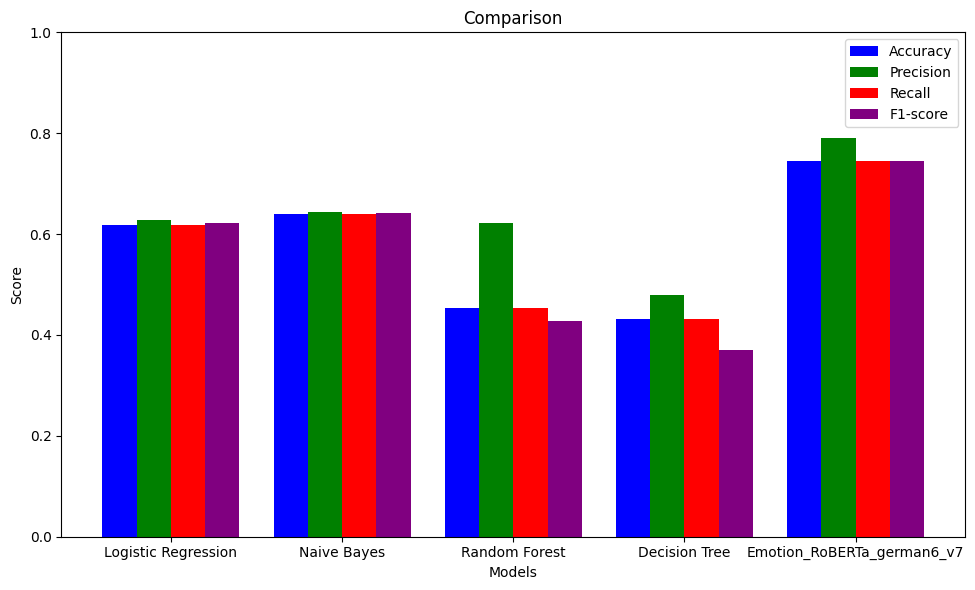

In [26]:
# Dati per il grafico
labels = list(models.keys())
labels.append("Emotion_RoBERTa_german6_v7")
metrics["accuracy"]["Emotion_RoBERTa_german6_v7"] = hf_accuracy
metrics["weightedPrecision"]["Emotion_RoBERTa_german6_v7"] = hf_precision
metrics["weightedRecall"]["Emotion_RoBERTa_german6_v7"] = hf_recall
metrics["f1"]["Emotion_RoBERTa_german6_v7"] = hf_f1

# Grafico
bar_width = 0.2
index = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(index - 1.5 * bar_width, [metrics["accuracy"][m] for m in labels], bar_width, label="Accuracy", color='blue')
ax.bar(index - 0.5 * bar_width, [metrics["weightedPrecision"][m] for m in labels], bar_width, label="Precision", color='green')
ax.bar(index + 0.5 * bar_width, [metrics["weightedRecall"][m] for m in labels], bar_width, label="Recall", color='red')
ax.bar(index + 1.5 * bar_width, [metrics["f1"][m] for m in labels], bar_width, label="F1-score", color='purple')
ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Comparison")
ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()